In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

2025-11-16 12:27:54.298153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763296074.490292      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763296074.541634      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
train_dir = '/kaggle/input/dataset-lab4/seg'
test_dir = '/kaggle/input/dataset-lab4/seg_test'

In [3]:
img_height, img_width = 224, 224
batch_size = 8
epochs = 30
num_classes = 6

In [4]:
# Data preprocessing với augmentation cho tập train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.4,
    horizontal_flip=True,
    validation_split=0.2  
)

# Chỉ rescale cho tập test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load dữ liệu
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Số lượng classes: {train_generator.num_classes}")
print(f"Classes: {train_generator.class_indices}")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Số lượng classes: 6
Classes: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [5]:
# Xây dựng model DenseNet121
def build_densenet121_model():
    print("Loading DenseNet121 pretrained weights...")
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )
    print("DenseNet121 base model loaded!")
    
    # Đóng băng các layers của base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Thêm các layers tùy chỉnh - DenseNet121 (output: 1024 features)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # (None, 7, 7, 1024) -> (None, 1024)
    x = Dense(512, activation='relu')(x)  # 1024 -> 512
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)  # 512 -> 512
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Tạo model hoàn chỉnh
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [6]:
model = build_densenet121_model()
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Loading DenseNet121 pretrained weights...


I0000 00:00:1763296101.078927      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763296101.079562      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DenseNet121 base model loaded!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,828,038 (29.86 MB)

 Trainable params: 790,534 (3.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [7]:
# Callbacks
checkpoint = ModelCheckpoint(
    'models/densenet121_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False, 
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [8]:
# Tạo thư mục lưu model
os.makedirs('models', exist_ok=True)
print("\nModels directory ready.")


Models directory ready.


In [9]:
# Training
print("BẮT ĐẦU TRAINING DENSENET121")
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

# Lưu model cuối cùng
model.save('models/densenet121_final.h5')

BẮT ĐẦU TRAINING DENSENET121


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1763296117.418069     132 service.cc:148] XLA service 0x7ed8cc003e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763296117.418844     132 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763296117.418863     132 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763296120.110135     132 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1404 ━━━━━━━━━━━━━━━━━━━━ 9:30:50 24s/step - accuracy: 0.0000e+00 - loss: 2.3337

I0000 00:00:1763296129.767344     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6815 - loss: 0.8290
Epoch 1: val_accuracy improved from -inf to 0.86733, saving model to models/densenet121_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 276s 179ms/step - accuracy: 0.6816 - loss: 0.8288 - val_accuracy: 0.8673 - val_loss: 0.3463 - learning_rate: 1.0000e-04
Epoch 2/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8565 - loss: 0.3822
Epoch 2: val_accuracy improved from 0.86733 to 0.88588, saving model to models/densenet121_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 153s 109ms/step - accuracy: 0.8565 - loss: 0.3823 - val_accuracy: 0.8859 - val_loss: 0.3204 - learning_rate: 1.0000e-04
Epoch 3/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8717 - loss: 0.3478
Epoch 3: val_accuracy improved from 0.88588 to 0.88837, saving model to models/densenet121_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 155s 110ms/step - accuracy: 0.8717 - loss: 0.3478 - val_accuracy: 0.8884 - val_loss: 0.3003 - learning_rate: 1.0000e-04
Epoch 4/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8781 - loss: 0.3318
Epoch 4: val_accuracy improved from 0.88837 to 0.89230, saving model to models/densenet121_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 155s 110ms/step - accuracy: 0.8781 - loss: 0.3318 - val_accuracy: 0.8923 - val_loss: 0.2871 - learning_rate: 1.0000e-04
Epoch 5/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8823 - loss: 0.3259
Epoch 5: val_accuracy did not improve from 0.89230
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 153s 109ms/step - accuracy: 0.8823 - loss: 0.3259 - val_accuracy: 0.8859 - val_loss: 0.3008 - learning_rate: 1.0000e-04
Epoch 6/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8866 - loss: 0.3168
Epoch 6: val_accuracy did not improve from 0.89230
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 153s 109ms/step - accuracy: 0.8866 - loss: 0.3168 - val_accuracy: 0.8905 - val_loss: 0.3010 - learning_rate: 1.0000e-04
Epoch 7/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8908 - loss: 0.2990
Epoch 7: val_accuracy did not improve from 0.89230
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 152s 109ms/step - accuracy: 0.8908 - loss: 0.2990 - val_accuracy: 0.8805 - val_loss: 0.3210 - le

1404/1404 ━━━━━━━━━━━━━━━━━━━━ 154s 110ms/step - accuracy: 0.8925 - loss: 0.3006 - val_accuracy: 0.9012 - val_loss: 0.2764 - learning_rate: 1.0000e-04
Epoch 9/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9005 - loss: 0.2711
Epoch 9: val_accuracy did not improve from 0.90121
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 158s 113ms/step - accuracy: 0.9005 - loss: 0.2711 - val_accuracy: 0.8955 - val_loss: 0.2759 - learning_rate: 1.0000e-04
Epoch 10/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8924 - loss: 0.2906
Epoch 10: val_accuracy improved from 0.90121 to 0.90549, saving model to models/densenet121_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 155s 110ms/step - accuracy: 0.8924 - loss: 0.2906 - val_accuracy: 0.9055 - val_loss: 0.2753 - learning_rate: 1.0000e-04
Epoch 11/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8981 - loss: 0.2729
Epoch 11: val_accuracy did not improve from 0.90549
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 153s 109ms/step - accuracy: 0.8981 - loss: 0.2729 - val_accuracy: 0.8955 - val_loss: 0.2833 - learning_rate: 1.0000e-04
Epoch 12/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8992 - loss: 0.2658
Epoch 12: val_accuracy did not improve from 0.90549
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 153s 109ms/step - accuracy: 0.8992 - loss: 0.2658 - val_accuracy: 0.8973 - val_loss: 0.2829 - learning_rate: 1.0000e-04
Epoch 13/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8996 - loss: 0.2627
Epoch 13: val_accuracy did not improve from 0.90549
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 152s 108ms/step - accuracy: 0.8996 - loss: 0.2627 - val_accuracy: 0.8937 - val_loss: 0.281

1404/1404 ━━━━━━━━━━━━━━━━━━━━ 154s 109ms/step - accuracy: 0.9153 - loss: 0.2228 - val_accuracy: 0.9080 - val_loss: 0.2584 - learning_rate: 5.0000e-05
Epoch 22/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9176 - loss: 0.2200
Epoch 22: val_accuracy did not improve from 0.90799
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 151s 107ms/step - accuracy: 0.9176 - loss: 0.2200 - val_accuracy: 0.8973 - val_loss: 0.2730 - learning_rate: 5.0000e-05
Epoch 23/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9110 - loss: 0.2254
Epoch 23: val_accuracy improved from 0.90799 to 0.91476, saving model to models/densenet121_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 153s 109ms/step - accuracy: 0.9110 - loss: 0.2254 - val_accuracy: 0.9148 - val_loss: 0.2505 - learning_rate: 5.0000e-05
Epoch 24/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9226 - loss: 0.2148
Epoch 24: val_accuracy did not improve from 0.91476
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 152s 108ms/step - accuracy: 0.9226 - loss: 0.2148 - val_accuracy: 0.9080 - val_loss: 0.2659 - learning_rate: 5.0000e-05
Epoch 25/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9214 - loss: 0.2099
Epoch 25: val_accuracy did not improve from 0.91476
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 151s 108ms/step - accuracy: 0.9214 - loss: 0.2099 - val_accuracy: 0.9112 - val_loss: 0.2585 - learning_rate: 5.0000e-05
Epoch 26/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9192 - loss: 0.2064
Epoch 26: val_accuracy did not improve from 0.91476
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 152s 108ms/step - accuracy: 0.9192 - loss: 0.2064 - val_accuracy: 0.9101 - val_loss: 0.259

In [10]:
print("\n========== ĐÁNH GIÁ TRÊN TẬP TEST ==========\n")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


========== ĐÁNH GIÁ TRÊN TẬP TEST ==========

375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9187 - loss: 0.2098
Test Loss: 0.2164
Test Accuracy: 0.9223


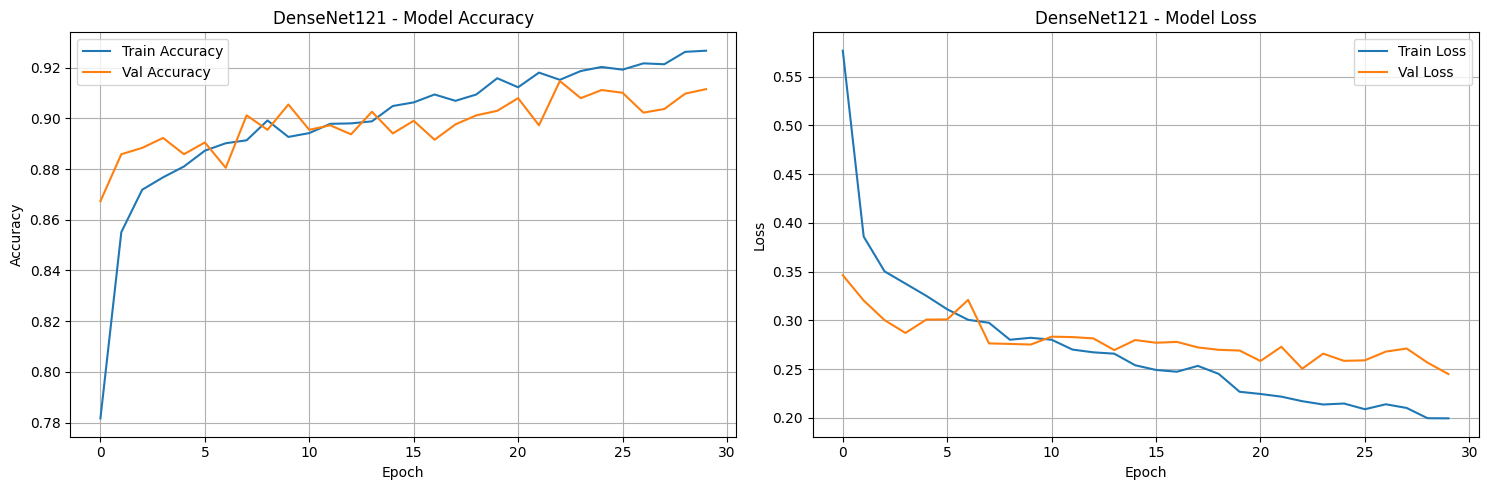

In [11]:
# Vẽ biểu đồ training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('DenseNet121 - Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('DenseNet121 - Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('results/densenet121_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Tạo thư mục results
os.makedirs('results', exist_ok=True)

# Vẽ biểu đồ
plot_training_history(history)